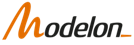

# Redeclare component using the Modelon Impact Client Library
This notebook will showcase how to redeclare a model component (the wheels in this case) using the [Modelon Impact Client Library](https://modelon-impact-client.readthedocs.io/en/latest/)(MIC).

## Approach
To showcase how redeclaration can be done, we will perform the following steps:

1. Create a client object and authenticate
2. Configure analysis
3. Run base model and inspect result
4. Redeclare the wheel model
5. Run tweaked model again and compare results
6. Upload external .mo file with wheel model
7. Redeclare model to use this for redeclaration
8. Run again
9. Delete uploaded model

Note there are some basic steps that needs to be performed before start using MIC, documentation is linked below:

1. Install MIC: https://modelon-impact-client.readthedocs.io/en/latest/install.html
2. Authentication: https://modelon-impact-client.readthedocs.io/en/latest/setup.html

If you are running Modelon Impact Cloud, MIC is installed by default, so the installation step can be skipped.

**Note!** For Modelon Impact 1.2.6, MIC v1.1.0 should be used:

In [ ]:
import sys

!{sys.executable} -m pip show modelon-impact-client
#!{sys.executable} -m pip install modelon-impact-client==1.1.0

## Create a client object and authenticate
The client object contains methods to authenticate logins, create new workspaces and
upload or fetch existing workspaces

The class constructor has two important parameters:
   - `url`:
       - The URL for Modelon Impact client host. Default is 'http://localhost:8080/', which is used by default for a desktop installation. This is also the URL that should be used if you are using JupyterLab on Modelon Impact Cloud.

   - `interactive`:
       - Asks you to enter an api_key from the prompt. When the key has been entered the first time, it will be stored in the credentials file to be used in future requests, and the prompt will not be shown again. If the key is changed, the file may be deleted which will cause the prompt to be shown again.

In the below cell, a client object is instantiated. Make sure that the URL is pointing towards your Modelon Impact server. When executed, it will also ask for an api key, please go ahead and provide your personal key generated with the API key manager.

In [ ]:
from modelon.impact.client import Client

client=Client(url="http://localhost:8080/",interactive=True)

This api key will be stored in a credentials file named api.key and located in the directory .impact in the user's home folder.

## Configure analysis

In below cell a standard dynamic simulation is setup for the model `Perseverance.Experiments.DrivingCleats`.

In [ ]:
model_name = "Perseverance.Experiments.DrivingCleats"
workspace = client.get_workspace("MarsRovers")
analysis = workspace.get_custom_function('dynamic').with_parameters(start_time=0.0, final_time=20.0)
model = workspace.get_model(model_name)

We use default options, but compiler, runtime and simulation options can be edited if needed.

In [ ]:
compiler_options = analysis.get_compiler_options()
runtime_options = analysis.get_runtime_options()
simulation_options = analysis.get_simulation_options()

Experiment definitions are set up using the `.new_experiment_definition()` method from the model object. After this step we are ready to simulate.

In [ ]:
experiment_definition = model.new_experiment_definition(analysis, compiler_options=compiler_options, runtime_options=runtime_options, simulation_options=simulation_options)

## Run base model and inspect the result

The experiment definition we have set up can now be passed to the `execute()` method of the workspace object. This will send a request to the server telling it to execute the declared experiment setup in the workspace related to the workspace object. We use the `wait()` method as the execution will take some time to perform. Once the experiment execution is completed, it will return an Experiment object representing the experiment result. The experiment will compile the model if necessery, i.e. if there is no previously compiled fmu of the same model in the workspace.

The `wait()` method generates a lot of logging output, which can be suppressed using Python's built in `logging` module (default is INFO).

In [ ]:
import logging

logging.getLogger('modelon.impact.client').setLevel(logging.INFO)

In [ ]:
exp = workspace.execute(experiment_definition).wait()

Experiments are divided into cases. For the previous definition we only have one case. We can inspect the results for a specific case by calling the Experiment object's `get_trajectories()` method and using matplotlib to do the actual plotting. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
case = exp.get_case('case_1')
res = case.get_trajectories()
plt.plot(res['time'], res['chassis.summary_v_x'], label='chassis.v_x - orig')
plt.legend()
plt.show()
plt.close(1)

## Redeclare the wheel model
 
Currently there is no direct support to redeclare classes or components from MIC. However it is possible to achieve the same result by adding the redeclaring modifier directly to the class name.
 
We will achieve the redeclaration of the wheel class by using this method.

In [ ]:
redeclare_string = "(chassis(redeclare model Wheel = .Perseverance.Wheel_2))"
model_name_redeclare = model_name + redeclare_string
model_redeclare = workspace.get_model(model_name_redeclare)

Next, we need to create an experiment_definition similiar to how we did it earlier, using the same analysis and options.

In [ ]:
experiment_definition_redeclare = model_redeclare.new_experiment_definition(analysis, compiler_options=compiler_options, runtime_options=runtime_options, simulation_options=simulation_options)

Finally we can execute the experiment...

In [ ]:
exp_redeclare = workspace.execute(experiment_definition_redeclare).wait()

... and compare the results side by side.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
case_redeclare = exp_redeclare.get_case('case_1')
res_redeclare = case_redeclare.get_trajectories()
plt.plot(res['time'], res['chassis.summary_v_x'], label='chassis.v_x - orig')
plt.plot(res_redeclare['time'], res_redeclare['chassis.summary_v_x'], label='chassis.v_x - redeclared')
plt.legend()
plt.show()
plt.close(1)

## Upload external .mo file with wheel model

In case the intended model to be used for redeclaration does not sit inside your workspace, it is possible to upload it as an external file.

In [ ]:
import os
from modelon.impact.client.sal.exceptions import HTTPError

file_folder_path = os.getcwd()
file_name = 'Wheel_3.mo'
file_path = os.path.join(file_folder_path, file_name)

try:
    workspace.upload_model_library(file_path)
except HTTPError as e:
    print(f"HTTPErrror: {e}")

## Redeclare model to use this for redeclaration

Once uploaded, we can use this model in the vehicle by redeclaring the wheel model. The model search path will be the same as in the uploaded library/model. If you use the included model file, it is simply `Wheel_3`.

In [ ]:
upload_redeclare_string = "(chassis(redeclare model Wheel = Wheel_3))"
model_name_upload_redeclare = model_name + upload_redeclare_string
model_upload_redeclare = workspace.get_model(model_name_upload_redeclare)

## Run again

To run the model again, we need to create a new experiment definition based on the new model.

In [ ]:
experiment_definition_upload_redeclare = model_upload_redeclare.new_experiment_definition(analysis, compiler_options=compiler_options, runtime_options=runtime_options, simulation_options=simulation_options)

And execute it in the selected workspace.

In [ ]:
exp_upload_redeclare = workspace.execute(experiment_definition_upload_redeclare).wait()

For the curious modeller we can plot the result against the original result.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
case_upload_redeclare = exp_upload_redeclare.get_case('case_1')
res_upload_redeclare = case_upload_redeclare.get_trajectories()
plt.plot(res['time'], res['chassis.summary_v_x'], label='chassis.v_x - orig')
plt.plot(res_upload_redeclare['time'], res_upload_redeclare['chassis.summary_v_x'], label='chassis.v_x - uploaded wheel')
plt.legend()
plt.show()
plt.close(1)

## More info

For more detailed information on the Modelon-impact-client library please look at the offical documentation page:

https://modelon-impact-client.readthedocs.io/en/latest/

Copyright (C) 2022 [Modelon](http://www.modelon.com/)